In [1]:
from rdflib import Graph, Namespace, Literal, URIRef

# load_turtle_graph

print("Loading RDF graph...")
ns = Namespace("http://example.org/movielens#")
graph = Graph()
graph.parse("data/ml-100k/graph.turtle", format='turtle')

Loading RDF graph...


<Graph identifier=Neb6dd7906c07426db2671087b905d530 (<class 'rdflib.graph.Graph'>)>

In [2]:
# Verify that the graph is loaded correctly
edge_count = 0
for triple in graph:
    edge_count += 1

print("Nodes: ", len(graph.all_nodes()))
print("Edges: ", edge_count)

Nodes:  155603
Edges:  513452


In [3]:
# encode_graph

import pandas as pd
from rdflib.namespace import RDF, RDFS

filterEdgeTypes = [RDF.type, ns.timestamp, RDFS.label, ns.imdb_url, ns.release_date, ns.age]

print("Encoding RDF graph...")
if graph is None:
    raise Exception("No graph loaded. Load a graph first using load_turtle_graph()")
edge_data = []
nodes_data = []
node_to_int_mapping = {}
int_to_node_mapping = {}
node_count = 0
for s, p, o in graph:
    # Filter out edges of the specified type
    if filterEdgeTypes is not None and p in filterEdgeTypes:
        continue
    
    # Encode nodes as integers
    for node in [s, o]:
        # Skip nodes that are already encoded
        if node in node_to_int_mapping:
            continue
        # Find node type
        node_type = graph.value(node, RDF.type)
        # Filter out rating nodes
        if node_type == ns.Rating:
            break
        # Update mapping
        node_to_int_mapping[node] = node_count
        int_to_node_mapping[node_count] = node
        node_count += 1
        # Add node to DataFrame
        nodes_data.append((node, node_type))
    else:
        # Add edge to DataFrame
        source = node_to_int_mapping.get(s)
        target = node_to_int_mapping.get(o)
        edge_type = p
        edge_data.append((source, target, edge_type))

# Get weights from ratings
for s, p, o in graph.triples((None, RDF.type, ns.Rating)):
    user = graph.value(s, ns.user)
    item = graph.value(s, ns.item)
    rating = graph.value(s, ns.rating)
    edge_data.append((node_to_int_mapping.get(user), node_to_int_mapping.get(item), ns.rating, int(rating.toPython())))

edges_df = pd.DataFrame(edge_data, columns=["Source", "Target", "Type", "Rating"])
nodes_df = pd.DataFrame(nodes_data, columns=["Node", "Type"])

print("Node and Edge DataFrames created.")


Encoding RDF graph...
Node and Edge DataFrames created.


In [4]:
# Node information summary

print(nodes_df.head())
print(nodes_df["Type"].value_counts())
nodes_df.to_csv("../data/ml-100k/kg_nodes.csv", index=False)

                                    Node  \
0   http://example.org/movielens#user369   
1  http://example.org/occupation#student   
2  http://example.org/movielens#item1371   
3       http://example.org/genre#genre11   
4   http://example.org/movielens#user250   

                                      Type  
0        http://example.org/movielens#User  
1  http://example.org/movielens#Occupation  
2        http://example.org/movielens#Item  
3       http://example.org/movielens#Genre  
4        http://example.org/movielens#User  
Type
http://example.org/movielens#Item          1682
http://example.org/movielens#User           943
http://example.org/movielens#Occupation      21
http://example.org/movielens#Genre           19
Name: count, dtype: int64


In [5]:
# Edge information summary

print(edges_df.head())
print(edges_df["Type"].value_counts())
edges_df[["Source","Target"]].to_csv("../data/ml-100k/kg_edges.csv", index=False, header=False, sep=" ")

   Source  Target                                     Type  Rating
0       0       1  http://example.org/movielens#occupation     NaN
1       2       3       http://example.org/movielens#genre     NaN
2       4       5      http://example.org/movielens#gender     NaN
3       6       7       http://example.org/movielens#genre     NaN
4       8       9       http://example.org/movielens#genre     NaN
Type
http://example.org/movielens#rating        100000
http://example.org/movielens#genre           2893
http://example.org/movielens#occupation       943
http://example.org/movielens#gender           943
Name: count, dtype: int64


In [6]:
import networkx as nx

# Create an empty graph
KG = nx.Graph()

# Iterate over the rows of the DataFrame and add edges with weights
for row in edges_df.itertuples(index=False):
    source = row.Source
    target = row.Target
    weight = row.Rating
    
    # Skip edges with NaN weights
    if pd.isna(weight):
        KG.add_edge(source, target, weight=5)
    else:
        KG.add_edge(source, target, weight=weight)

KG.number_of_nodes(), KG.number_of_edges()

# Verify that the graph does not contain any weights with NaN values
for source, target, weight in KG.edges.data("weight"):
    if pd.isna(weight):
        print(source, target, weight)

# Analyze only greatest (weakly) connected component of our knowledge graph
largest_cc = max(nx.connected_components(KG), key=len)
KG = nx.subgraph(KG, largest_cc)
KG.number_of_nodes(), KG.number_of_edges()

# Save the graph
nx.write_gpickle(KG, "../data/ml-100k/kg.gpickle")

In [7]:
# Load the graph
#KG = nx.read_gpickle("../data/ml-100k/kg.gpickle")

In [8]:
# %%time
# from node2vec import Node2Vec
# n2v_obj = Node2Vec(KG, dimensions=10, walk_length=5, num_walks=10, p=1, q=1, workers=4, weight_key="weight")

In [9]:
# %%time
# n2v_model = n2v_obj.fit(window=3, min_count=1, batch_words=4)

# embeddings = n2v_model.wv

In [10]:
# from gensim.models import KeyedVectors

# # Save the embeddings to a file
# embeddings.save_word2vec_format('../data/ml-100k/embeddings.txt')

In [11]:
from gensim.models import KeyedVectors

# Load the saved embeddings from the file
embeddings = KeyedVectors.load_word2vec_format('../data/ml-100k/embeddings.txt')

In [12]:
# Visualization: reduce dimensionality of embeddings with t-SNE

%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np

def get_embeddings(nodes):
    """Extract representations from the node2vec model"""
    emb = [list(embeddings.get_vector(n)) for n in nodes]
    emb = np.array(emb)
    print(emb.shape)
    return emb

def dim_reduction(embeddings, labels, frac=None, tsne_obj=TSNE(n_components=2)):
    """Dimensionality reduction with t-SNE. Sampling random instances is supported."""
    N = len(embeddings)
    print(N)
    if frac != None:
        idx = np.random.randint(N, size=int(N*frac))
        X = embeddings[idx,:]
        X_labels = [labels[i] for i in idx]
    else:
        X = embeddings
        X_labels = labels
    X_embedded = tsne_obj.fit_transform(X)
    print("t-SNE object was trained on %i records!" % X.shape[0])
    print(X_embedded.shape)
    return X_embedded, X_labels

def visu_embeddings(X_embedded, tsne_labels, X_labels=None, colors = ['r','b']):
    if X_labels != None:
        label_map = {}
        for i, l in enumerate(tsne_labels):
            if not l in label_map:
                label_map[l] = []
            label_map[l].append(i)
        fig, ax = plt.subplots(figsize=(15,15))
        for i, lab in enumerate(label_map.keys()):
            print(lab)
            idx = label_map[lab]
            x = list(X_embedded[idx,0])
            y = list(X_embedded[idx,1])
            #print(len(x),len(y))
            ax.scatter(x, y, c=colors[i], label=lab, alpha=0.5, edgecolors='none')
        plt.legend()
    else:
        plt.figure(figsize=(15,15))
        x = list(X_embedded[:,0])
        y = list(X_embedded[:,1])
        plt.scatter(x, y, alpha=0.5)

In [14]:
movies = list(nodes_df[nodes_df["Type"] == ns["Item"]].index)
users = list(nodes_df[nodes_df["Type"] == ns["User"]].index)
print(len(movies), len(users))
movies = list(set(movies).intersection(set(KG.nodes())))
users = list(set(users).intersection(set(KG.nodes())))
print(len(movies), len(users))

# Color movies by genre
movie_lbls = [graph.value(int_to_node_mapping[int(movie)], ns.genre).toPython() for movie in movies]

# Color users by age
user_lbls = [int(graph.value(int_to_node_mapping[int(user)], ns.age).toPython()) for user in users]

# Regroup ages into 3 categories
for lbl in user_lbls:
    if int(lbl) < 25:
        user_lbls[user_lbls.index(lbl)] = "0-24"
    elif int(lbl) < 45:
        user_lbls[user_lbls.index(lbl)] = "25-44"
    else:
        user_lbls[user_lbls.index(lbl)] = "45+"

movies = [str(item) for item in movies]
users = [str(user) for user in users]

1682 943
1682 943


In [15]:
movie_emb = get_embeddings(movies)
user_emb = get_embeddings(users)

(1682, 10)
(943, 10)


In [16]:
%%time
movie_tsne_emb, movie_tsne_lbls = dim_reduction(movie_emb, movie_lbls)

1682
t-SNE object was trained on 1682 records!
(1682, 2)
CPU times: total: 1min 35s
Wall time: 18.2 s


In [17]:
%%time
user_tsne_emb, user_tsne_lbls = dim_reduction(user_emb, user_lbls)

943
t-SNE object was trained on 943 records!
(943, 2)
CPU times: total: 46.9 s
Wall time: 8.02 s


http://example.org/genre#genre3
http://example.org/genre#genre1
http://example.org/genre#genre6
http://example.org/genre#genre5
http://example.org/genre#genre12
http://example.org/genre#genre11
http://example.org/genre#genre8
http://example.org/genre#genre4
http://example.org/genre#genre10


IndexError: list index out of range

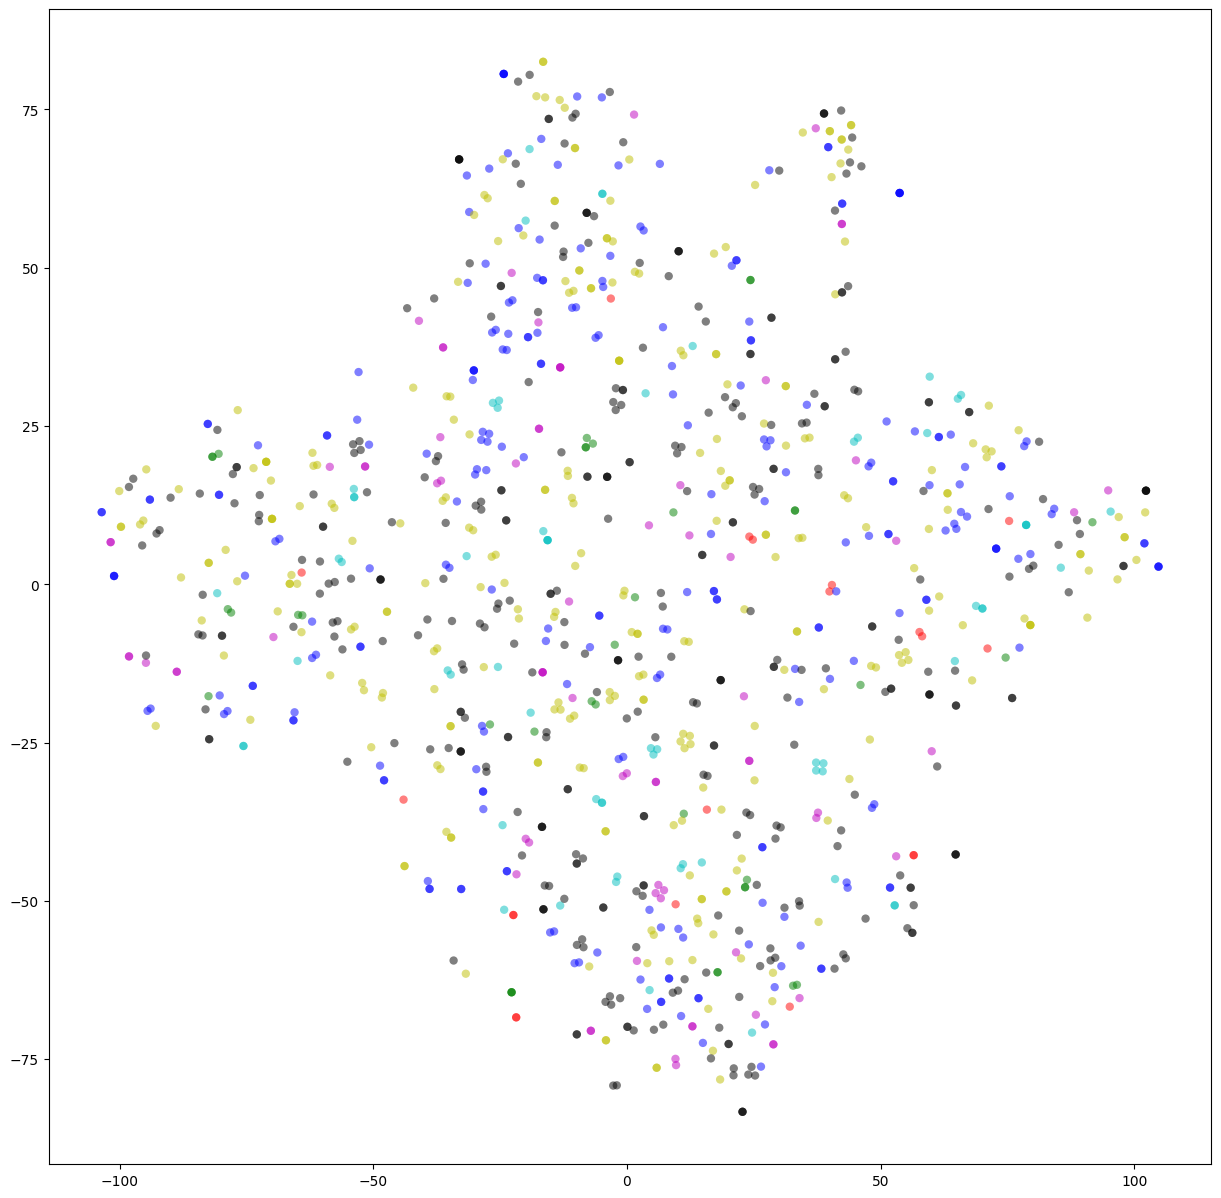

In [23]:
visu_embeddings(movie_tsne_emb, movie_tsne_lbls, X_labels=movie_lbls, colors=['r','b','g','y','c','m','k','w', ])